### Анна Тимошенко

In [1]:
import pandas as pd
import pandahouse as ph
from scipy.stats import ttest_ind
import seaborn as sns

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-07-06' and '2022-07-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [3]:
%%time
pvalues = []
for q in range(10000):
    group2_500 = df[df.exp_group == 2].user_id.sample(n=500, random_state=q, replace=False)
    group3_500 = df[df.exp_group == 3].user_id.sample(n=500, random_state=q, replace=False)
    pvalues.append(ttest_ind(df[df.user_id.isin(group2_500)].ctr,
                df[df.user_id.isin(group3_500)].ctr,
                equal_var=False)[1])

CPU times: user 1min 16s, sys: 435 ms, total: 1min 17s
Wall time: 1min 17s


## 1. Построить гистограмму распределения получившихся 10000 p-values

<AxesSubplot:ylabel='Count'>

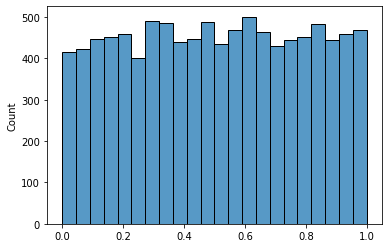

In [4]:
sns.histplot(data=pvalues)

## 2. Посчитать, какой процент p values оказался меньше либо равен 0.05

In [5]:
print((100 * len([p for p in pvalues if p <= 0.05]) / len(pvalues)), '% - процент p-values меньше либо равных 0.05')

4.52 % - процент p-values меньше либо равных 0.05


## 3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования

Равномерное распределение p-value - это хороший знак. Если примем уровень $\alpha$ = 0.05, можно делать вывод, что выборки 2 и 3 статистически не отличаются (менее чем в 5% случаев t-test выдаёт p-value <= 0.05, то есть говорит о различиях между выборками - "ложноположительное срабатывание"). Система сплитования работает корректно.